# Implementing Resnet from scratch with Pytorch
## Imports

In [2]:
import torch
import torch.nn as  nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


## Data exploration

In [4]:
data_dir = "/home/ec2-user/SageMaker/wikiart_binary"

In [5]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [6]:
random_seed = 42
torch.manual_seed(random_seed);

In [7]:
val_size = int(len(dataset)*0.2)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(30104, 7525)

In [26]:
batch_size = 256

In [27]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [28]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
show_batch(train_dl)

## General functions

In [9]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Resnet from scratch

In [11]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x
    

In [12]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x
    

In [13]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)
    

In [14]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [15]:
# from ResNet import Bottleneck, ResNet, ResNet50
os.getcwd()

'/home/ec2-user/SageMaker/Masters-thesis/Classifier'

In [16]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = Path("/home/ec2-user/SageMaker/wikiart_binary")

# Number of classes in the dataset
num_classes = 2

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, efficientnet, wide_resnet, regnet]
model_name = ResNet50(num_classes, channels=3)

# Batch size for training (change depending on how much memory you have)
batch_size = 256

# Number of epochs to train for
num_epochs = 1

# Input Size
input_size = 224

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    df = pd.DataFrame(columns=['Epoch','Phase','Loss','Accuracy'])
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            df = df.append({'Epoch':epoch,'Phase':phase,'Loss':epoch_loss,'Accuracy':epoch_acc},ignore_index=True)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [18]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [19]:
feature_extract = False

In [20]:
model_ft = ResNet50(num_classes, channels=3)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [22]:
# Send the model to GPU
model_ft = model_ft.to(device)
retraining = 32
i = 0

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
n_params = len(list(params_to_update))
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if n_params -i > retraining:
            i+=1
        else:
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
#     params_to_update = params_to_update[-retraining]
print(len(params_to_update))

Params to learn:
	 layer4.0.batch_norm3.weight
	 layer4.0.batch_norm3.bias
	 layer4.0.i_downsample.0.weight
	 layer4.0.i_downsample.0.bias
	 layer4.0.i_downsample.1.weight
	 layer4.0.i_downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.conv1.bias
	 layer4.1.batch_norm1.weight
	 layer4.1.batch_norm1.bias
	 layer4.1.conv2.weight
	 layer4.1.conv2.bias
	 layer4.1.batch_norm2.weight
	 layer4.1.batch_norm2.bias
	 layer4.1.conv3.weight
	 layer4.1.conv3.bias
	 layer4.1.batch_norm3.weight
	 layer4.1.batch_norm3.bias
	 layer4.2.conv1.weight
	 layer4.2.conv1.bias
	 layer4.2.batch_norm1.weight
	 layer4.2.batch_norm1.bias
	 layer4.2.conv2.weight
	 layer4.2.conv2.bias
	 layer4.2.batch_norm2.weight
	 layer4.2.batch_norm2.bias
	 layer4.2.conv3.weight
	 layer4.2.conv3.bias
	 layer4.2.batch_norm3.weight
	 layer4.2.batch_norm3.bias
	 fc.weight
	 fc.bias
32


In [23]:
criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.Adam(params_to_update, lr=0.0005)
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor = 0.1, patience=5)

In [24]:
# Setup the loss fxn for multi-class
# criterion = nn.CrossEntropyLoss()

# Train and evaluate
# model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [25]:
name = "wikiart-cropped-post-resnetscratch.pth"
saving_dir = Path("/home/ec2-user/SageMaker/models/",name)
# torch.save(model_ft.state_dict(), saving_dir)

# Visualize

In [29]:
import tqdm
from torch.utils.data import DataLoader, Dataset

In [44]:
data_dir = "/home/ec2-user/SageMaker/style_64"
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

val_size = int(len(dataset)*0.2)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [45]:
batch = 128

In [46]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

In [47]:
# dataloader.label

In [48]:
# model = model_ft
# model.eval()

# for batch in dataloader:
#     print(batch[2])

In [49]:
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img[0]

Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


tensor([[0.7098, 0.7569, 0.7255,  ..., 0.1569, 0.1843, 0.1765],
        [0.7059, 0.7686, 0.6941,  ..., 0.0784, 0.0667, 0.0588],
        [0.7451, 0.7294, 0.7804,  ..., 0.0745, 0.0902, 0.0745],
        ...,
        [0.6392, 0.6039, 0.6706,  ..., 0.6353, 0.5569, 0.6196],
        [0.6863, 0.6667, 0.6902,  ..., 0.6118, 0.5216, 0.5843],
        [0.6784, 0.7255, 0.6902,  ..., 0.5176, 0.6784, 0.5725]])

In [43]:
img[2][0][0]

tensor(0.4588)

In [38]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.reshape(img,[224,224,3])
# print(img)
label = train_labels[0]
# print(label)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


TypeError: reshape(): argument 'shape' (position 1) must be tuple of ints, not Tensor

In [46]:
model = model_ft
model.eval()

for batch in dataloader:
#     print(batch)
#     images = batch['image'].to(device)
#     labels += batch['label']
#     image_paths += batch['image_path']
    images = batch[0].to(device)
#     labels += batch[1]
#     image_paths += batch['image_path']

    output = model.forward(images)

    current_outputs = output.cpu().numpy()
    features = np.concatenate((outputs, current_outputs))

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 205520896 bytes. Error code 12 (Cannot allocate memory)


## Evaluate & deploy

In [652]:
# Create the model
model = model_ft

# Load state_dict
model.load_state_dict(torch.load('models/wikiart-cropped-binary-resnet50-32layers-60epochs-sgd.pth'),strict=False)

# load your image(s)
# data_dir = '/home/ec2-user/SageMaker/Masters-thesis/AC-WGAN tf/outputs/generated final/224/data'
data_dir = '/home/ec2-user/SageMaker/wikiart_binary/train/pre_1910s'
imgs = os.listdir(data_dir)
img = Image.open(data_dir+'/'+imgs[120])

# Create the preprocessing transformation here
transform = transforms.ToTensor()

# Transform
input = transform(img)

# unsqueeze batch dimension, in case you are dealing with a single image
input = input.unsqueeze(0)
input = input.cuda()

# Set model to eval
model.eval()

# Get prediction
output = model(input)
prob = nn.Sigmoid()(output)

In [653]:
output

tensor([[ 0.0154, -0.0476]], device='cuda:0', grad_fn=<AddmmBackward>)

In [654]:
prob

tensor([[0.5039, 0.4881]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [583]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [584]:
binary = model_ft.load_state_dict(torch.load('models/wikiart-cropped-binary-resnet50-32layers-60epochs-sgd.pth'),strict=False)
# model = to_device(model_ft, device)
# model.eval()

In [594]:
# torch.load('models/wikiart-cropped-binary-resnet50-32layers-60epochs-sgd.pth')

In [595]:
# binary

In [553]:
model_ft[0]

TypeError: 'ResNet' object does not support indexing

In [554]:
# torch.load('models/wikiart-cropped-binary-resnet50-32layers-60epochs-sgd.pth')

In [544]:
f = [binary[0][10],model_ft[0][10]]

TypeError: 'ResNet' object does not support indexing

In [509]:
f

['layer1.0.batch_norm2.weight', 'layer1.0.batch_norm2.weight']

In [479]:
# pre = model.load_state_dict(torch.load("models/wikiart-cropped-pre-resnet50-32layers-30epochs-sgd.pth"),strict=False)
# 

In [480]:
# post = model_ft.load_state_dict('models/wikiart-cropped-post-resnet50-32layers-60epochs-sgd.pth')


In [481]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [443]:
# plot_accuracies(hist)

In [444]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [445]:
# plot_losses(history)

In [422]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
#     xb = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [423]:
# data_dir = '/home/ec2-user/SageMaker/Masters-thesis/AC-WGAN tf/outputs/generated final/224'

In [424]:
test_dataset = ImageFolder(data_dir, transform=ToTensor())

In [425]:
model = to_device(model_ft, device)

In [426]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 56159
    Root location: /home/ec2-user/SageMaker/wikiart_binary
    StandardTransform
Transform: ToTensor()

In [427]:
test_dataset[50][1]

1

In [428]:
# img,lbl = test_dataset[6]
# plt.imshow(img.permute(1, 2, 0))
# print('Predicted:', predict_image(img, model_ft))

In [429]:
# predict_image(img, model_ft)

Label: pre_1910s , Predicted: pre_1910s


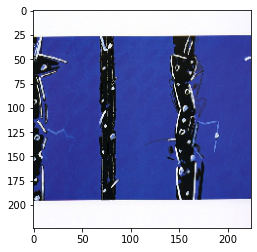

In [449]:
img, label = test_dataset[55]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))

In [450]:
correct = 0
total = 0
num_images = 5000
with torch.no_grad():
    for i in range(num_images):
        img, label = test_dataset[i]
        actual = dataset.classes[label]
        predicted = predict_image(img, model_ft)
        
        if actual == predicted:
            correct += 1
        total += 1
        
print('Accuracy on %d test images: ' % num_images, round(100*(correct/total),2), '%')

Accuracy on 5000 test images:  100.0 %


# Prediction on novel images

In [287]:
# checkpoint = torch.load('models/wikiart-cropped-binary-resnet50-32layers-60epochs-sgd.pth')
checkpoint = torch.load('models/wikiart-cropped-post-resnet50-32layers-60epochs-sgd.pth')
# checkpoint = torch.load("models/wikiart-cropped-pre-resnet50-32layers-30epochs-sgd.pth")
model = ResNet50(8, channels=3)
model.load_state_dict(checkpoint,strict = False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

In [288]:
#Data Transformation 
transformer = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) 
                                  ])

In [289]:
#Making preidctions on new data 
from PIL import Image
def prediction(img_path,transformer):
    image = Image.open(img_path).convert('RGB')
    image_tensor = transformer(image)
    image_tensor = image_tensor.unsqueeze_(0) #so img is not treated as a batch 
    input_img = Variable(image_tensor)
    output = model(input_img)
    #print(output)
    index = output.data.numpy().argmax()
    pred = classes[index]
    return pred 

In [290]:
import glob



In [291]:
from torch.autograd import Variable 


In [299]:
# pred_path = '/home/ec2-user/SageMaker/Masters-thesis/AC-WGAN tf/outputs/generated final/224/data'
pred_path = "/home/ec2-user/SageMaker/wikiart_post/train/Cubism"
test_imgs = glob.glob(pred_path+'/*')

In [300]:
root = Path("/home/ec2-user/SageMaker/wikiart_post/train")
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Abstract_Expressionism', 'Contemporary_Realism', 'Cubism', 'Expressionism', 'Fauvism', 'Minimalism', 'Naive_Art_Primitivism', 'Pop_Art']


In [301]:
# train_count = len(glob.glob(train_path+'/**/*.jpg')) + len(glob.glob(train_path+'/**/*.png')) + len(glob.glob(train_path+'/**/*.jpeg'))
# test_count = len(glob.glob(test_path+'/**/*.jpg')) + len(glob.glob(test_path+'/**/*.png')) + len(glob.glob(test_path+'/**/*.jpeg'))
# print(train_count,test_count)

In [302]:
test_imgs


['/home/ec2-user/SageMaker/wikiart_post/train/Cubism/henri-matisse_the-moraccans-1916.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/carlos-merida_native-couple-1939.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/juan-gris_woman-with-a-mandolin-after-corot-1916.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/salvador-dali_head-of-a-woman.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/juan-gris_girl.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/jury-annenkov_abram-efros-1921.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/umberto-boccioni_unique-forms-of-continuity-in-space-1913.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/fernand-leger_the-creation-of-the-world-bird-drawing-of-costume-1923.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/marc-chagall_green-lovers-1915.jpg',
 '/home/ec2-user/SageMaker/wikiart_post/train/Cubism/max-weber_figures-in-a-landscape.jpg',
 '/home/ec2-user/SageMaker/w

In [303]:
for i in test_imgs:
    print(prediction(i,transformer))
    
    
    

Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expressionism
Expres

KeyboardInterrupt: 